In [ ]:
pip install gym

In [ ]:
import gym
from gym import spaces
import numpy as np
import random
import copy

In [ ]:
class CustomFrozenLakeEnv(gym.Env):
    def __init__(self, start, end, size=100):
        self.size = size
        self.grid = np.zeros((size, size), dtype=int)
        self.observation_space = spaces.Discrete(size * size)
        self.action_space = spaces.Discrete(4)  # Four possible actions: 0=up, 1=down, 2=left, 3=right

        self.start = start
        self.goal = end
        self.num_holes = size * 2
        self.holes = self.generate_holes(self.num_holes)
        self.agent_position = self.start

        # Initialize transition probability matrix P
        self.P = self.generate_transition_matrix()

    def generate_holes(self, num_holes):
        holes = set()
        while len(holes) < num_holes:
            hole = (random.randint(0, self.size-1), random.randint(0, self.size-1))
            if hole != self.start and hole != self.goal:
                holes.add(hole)
        return holes

    def reset(self):
        self.agent_position = self.start
        return self.position_to_state(self.agent_position)

    def position_to_state(self, position):
        return position[0] * self.size + position[1]

    def state_to_position(self, state):
        return (state // self.size, state % self.size)

    def step(self, action):
        new_position = self.calculate_new_position(self.agent_position, action)

        # Check if new position is a hole or the goal
        if new_position in self.holes:
            reward = -1  # Negative reward for falling in a hole
            done = True
        elif new_position == self.goal:
            reward = 1  # Positive reward for reaching the goal
            done = True
        else:
            reward = 0  # Small negative reward for each step (to encourage faster solutions)
            done = False

        self.agent_position = new_position
        return self.position_to_state(self.agent_position), reward, done, {}

    def calculate_new_position(self, position, action):
        row, col = position
        if action == 0:  # Up
            row = max(row - 1, 0)
        elif action == 1:  # Down
            row = min(row + 1, self.size - 1)
        elif action == 2:  # Left
            col = max(col - 1, 0)
        elif action == 3:  # Right
            col = min(col + 1, self.size - 1)
        return (row, col)

    def render(self):
        grid = np.full((self.size, self.size), 'F')  # F for frozen ground
        grid[self.goal] = 'G'  # G for goal
        for hole in self.holes:
            grid[hole] = 'H'  # H for hole
        grid[self.agent_position] = 'A'  # A for agent
        print("\n".join(["".join(row) for row in grid]))
        print()

    def generate_transition_matrix(self):
        P = {}

        for state in range(self.observation_space.n):
            P[state] = {action: [] for action in range(self.action_space.n)}
            position = self.state_to_position(state)

            for action in range(self.action_space.n):
                new_position = self.calculate_new_position(position, action)
                new_state = self.position_to_state(new_position)

                if new_position in self.holes:
                    P[state][action].append((1.0, new_state, -1, True))  # Fell in a hole
                elif new_position == self.goal:
                    P[state][action].append((1.0, new_state, 1, True))  # Reached the goal
                else:
                    P[state][action].append((1.0, new_state, 0, False))  # Regular move

        return P

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = CustomFrozenLakeEnv((2,3), (4, 4), size=100)
env.reset()
env.render()

FFFFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFHFFHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFAFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFFFFFFFFFFHFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFGFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFHFFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF

In [ ]:
done = False
while not done:
    action = env.action_space.sample()  # Random action
    state, reward, done, _ = env.step(action)
    env.render()
    print(f"Action: {action}, State: {state}, Reward: {reward}, Done: {done}")


Streaming output truncated to the last 5000 lines.

Action: 1, State: 3602, Reward: 0, Done: False
FFFFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFHFFHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFFFFFFFFFFHFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFGFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
FFFFFFFFFFHFFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF

In [ ]:
class MDP():
  def __init__(self, num_states, num_actions, dynamics_fn):
    assert num_states > 0
    assert num_actions > 0
    self.num_states = num_states
    self.num_actions = num_actions
    self.dynamics_fn = dynamics_fn

    self.__verify()

  def __verify(self):
    assert len(self.dynamics_fn) == self.num_states

    for i in range(self.num_states):
      assert len(self.dynamics_fn[i]) == self.num_actions

    for i in self.dynamics_fn.keys():
      for j in self.dynamics_fn[i].keys():
        transitions = self.dynamics_fn[i][j]
        p_sum = sum([t[0] for t in transitions])
        assert p_sum <= 1 and p_sum > 0.99


In [ ]:
class Agent():
    def __init__(self, mdp, discount_rate=0.1, theta=0.05):
        self.mdp = mdp
        self.value_fn = [0] * self.mdp.num_states
        self.theta = theta
        num_a = self.mdp.num_actions
        num_s = self.mdp.num_states

        self.policy = []
        for s in range(num_s):
            p_s = [0] * num_a
            random_action = random.randint(0, num_a - 1)
            p_s[random_action] = 1
            self.policy.append(p_s)

        self.discount_rate = discount_rate

    def get_action(self, state):
        current_action_prob_dist = self.policy[state]
        action = np.random.choice(list(range(self.mdp.num_actions)), 1, p=current_action_prob_dist)
        return action[0]

    def eval_policy(self):
        delta = self.theta + 1
        while delta >= self.theta:
            delta = 0
            for s in range(self.mdp.num_states):
                old_value = self.value_fn[s]
                self.value_fn[s] = self.evaluate_policy_for_state(s)
                delta = max(delta, abs(old_value - self.value_fn[s]))

    def evaluate_policy_for_state(self, state, action=None):
        assert 0 <= state < self.mdp.num_states
        assert action is None or 0 <= action < self.mdp.num_actions
        value_s = 0
        if action is None:
            action = self.get_action(state)

        for transition in self.mdp.dynamics_fn[state][action]:
            pr_s_ = transition[0]  # probability of next state s_ given s and action
            s_ = transition[1]     # next state s_
            r_s_ = transition[2]   # reward for reaching s_
            value_s += pr_s_ * (r_s_ + self.discount_rate * self.value_fn[s_])
        return value_s

    def improve_policy(self, debug=True):
        stable = True
        for s in range(self.mdp.num_states):
            current_action = self.get_action(s)
            action_max = self.improve_policy_for_state(s)
            debug and print(f"State {s}, Action {current_action}, New action {action_max}")
            if action_max != current_action:
                stable = False
                self.policy[s][current_action] = 0
                self.policy[s][action_max] = 1
        return stable

    def improve_policy_for_state(self, state):
        assert 0 <= state < self.mdp.num_states
        v_s_max = float("-inf")
        action_max = None
        for action in range(self.mdp.num_actions):
            v_s = self.evaluate_policy_for_state(state, action)  # calculate q(s, a)
            if v_s > v_s_max:
                v_s_max = v_s
                action_max = action
        return action_max

    def policy_iteration(self, debug=False):
        is_policy_stable = False
        while not is_policy_stable:
            self.eval_policy()
            is_policy_stable = self.improve_policy(debug)
            debug and print(self.value_fn)
            debug and print(self.policy)

    def value_iteration(self, debug=False):
        # Find optimal value function
        delta = self.theta + 1
        while delta > self.theta:
            delta = 0
            debug and print(self.value_fn)
            for s in range(self.mdp.num_states):
                value_s_old = self.value_fn[s]
                for a in range(self.mdp.num_actions):
                    v_s_a = self.evaluate_policy_for_state(s, a)
                    self.value_fn[s] = max(v_s_a, self.value_fn[s])
                delta = max(delta, abs(value_s_old - self.value_fn[s]))

        # Extract optimal policy
        self.improve_policy(debug=debug)

    def print_agent_info(self):
        for s in range(self.mdp.num_states):
            a = self.get_action(s)
            v = self.value_fn[s]
            print(f"State {s}, policy(s): {a}, value(s): {v}")


In [ ]:
mdp = MDP(env.observation_space.n, env.action_space.n, env.unwrapped.P)

In [ ]:
 def run_experiment(env, agent, num_runs=1, render=False):
    tot_reward = [0]
    for _ in range(num_runs):
        observation = 0
        done = False
        env.reset()
        render and env.render()
        reward_per_run = 0
        while not done:
            action = agent.get_action(observation)
            observation, reward, done, info = env.step(action)
            reward_per_run += reward
            render and env.render()
        env.close()
        tot_reward.append(reward_per_run)
    return tot_reward

In [ ]:
agent1 = Agent(mdp, 0.9, 0.00000001)
agent1.policy_iteration()

agent2 = Agent(mdp, 0.9, 0.00000001)
agent2.value_iteration()

num_runs = 300
cumulative_rewards1 = run_experiment(env, agent1, num_runs)
cumulative_rewards2 = run_experiment(env, agent2, num_runs)

In [ ]:
cumulative_rewards1

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


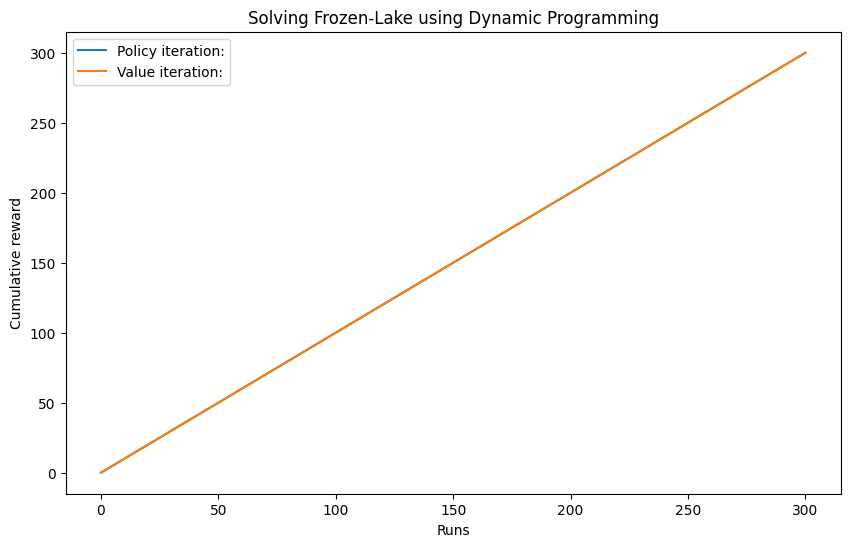

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes.
ax.plot(range(num_runs+1), cumulative_rewards1, label="Policy iteration:")
ax.plot(range(num_runs+1), cumulative_rewards2, label="Value iteration:")
ax.grid(False)
ax.set_xlabel('Runs')  # Add an x-label to the axes.
ax.set_ylabel('Cumulative reward')  # Add a y-label to the axes.
ax.set_title("Solving Frozen-Lake using Dynamic Programming")  # Add a title to the axes.
ax.legend()

cumulative_rewards1

Observations:
   

*  **Slow Convergence:** The algorithm takes a long time to converge, if it converges at all, and this delay increases with the size of the state space
*  **Sparse Rewards and Transitions:** The reward signal is weak, causing slower propagation of valuable information through the states.  
* **Increased State Space:** The agent has more states to consider, and since Value Iteration and Policy Iteration are exhaustive over all states, the large state space increases the time for the value function or policy to stabilize.




**Potential Solutions:**
    Use Approximate Methods: Rather than exact Value Iteration or Policy Iteration, using approximate methods like Q-learning or SARSA can make the process faster since they do not require a complete pass over all states.